# Teaching an RNN to sketch a circle

In [87]:
import numpy as np
import tensorflow as tf
import copy

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib notebook

In [88]:
class CircleWorld():
    def __init__(self, side):
        self.side = side
        self.max_steps = 5*side
        
        self.reset()
        
    def move_pen(self, action):
        if action is 0:
            self.pen_coord += np.asarray([0,1])
        elif action is 1:
            self.pen_coord += np.asarray([1,1])
        elif action is 2:
            self.pen_coord += np.asarray([1,0])
        elif action is 3:
            self.pen_coord += np.asarray([1,-1])
        elif action is 4:
            self.pen_coord += np.asarray([0,-1])
        elif action is 5:
            self.pen_coord += np.asarray([-1,-1])
        elif action is 6:
            self.pen_coord += np.asarray([-1,0])
        else:
            self.pen_coord += np.asarray([-1,1])
        
        r = 0
        if np.min(self.pen_coord) < 0 or np.max(self.pen_coord) >= self.side:
            r += -3
        self.pen_coord = self.pen_coord % self.side
        r += self.reward()
        
        self.canvas[self.pen_coord[0], self.pen_coord[1]] = 1
        return r
    
    def step(self, action):
        reward = self.move_pen(action)
        
        o1 = (self.template != self.canvas)*self.template
        o2 = np.zeros_like(o1); o2[self.pen_coord[0], self.pen_coord[1]] = 1
        observation = np.concatenate((o1,o2)).ravel().astype(np.float)
        
        done = False if self.global_step < self.max_steps else True
        self.global_step += 1
        info = None
        return observation, reward, done, info
    
    def reset(self):
        self.global_step = 0
        self.canvas = np.zeros((self.side, self.side))
        self.template = self.make_template(self.side)
        self.pen_coord = np.ones(2) * self.side/2
        
        o1 = (self.template != self.canvas)*self.template
        o2 = np.zeros_like(o1); o2[self.pen_coord[0], self.pen_coord[1]] = 1
        observation = np.concatenate((o1,o2)).ravel().astype(np.float)
        return observation
        
    def reward(self):
        x, y = self.pen_coord[0], self.pen_coord[1]
        if self.template[x, y] > 0:
            return self.template[x, y] - self.canvas[x, y]
        else:
            return 0
        
    @staticmethod
    def make_template(side):
        r = side/3
        template = np.zeros((side, side))
        x = np.linspace(0,2*np.pi,2*side)
        template[(r*np.cos(x)).astype(int) + side/2, (r*np.sin(x)).astype(int) + side/2] = 1
        x2 = np.linspace(side/2,side/2+r,side)
        template[int(side/2), (x2).astype(int)] = 1
        
        template = np.rot90(template, k=np.random.randint(4))
        return template

In [3]:
class Actor():
    def __init__(self, batch_size, tsteps, xlen, ylen):
        self.sess = tf.InteractiveSession()
        self.batch_size = batch_size
        self.xlen = xlen
        self.ylen = ylen
        self.x = x = tf.placeholder(tf.float32, shape=[None, None, xlen], name="x")
        self.y = y = tf.placeholder(tf.float32, shape=[None, None, ylen], name="y")
        
        self.params = params = {}
        self.fc1_size = fc1_size = 75
        self.rnn_size = rnn_size = 75
        with tf.variable_scope('actor',reuse=False):
            xavier_l1 = tf.truncated_normal_initializer(mean=0, stddev=1./np.sqrt(ylen), dtype=tf.float32)
            params['W1'] = tf.get_variable("W1", [xlen, fc1_size], initializer=xavier_l1)

            rnn_init = tf.truncated_normal_initializer(stddev=0.075, dtype=tf.float32)
            params['rnn'] = tf.nn.rnn_cell.LSTMCell(rnn_size, state_is_tuple=True, initializer=rnn_init)

            params['istate_batch'] = params['rnn'].zero_state(batch_size=batch_size, dtype=tf.float32)
            params['istate'] = params['rnn'].zero_state(batch_size=1, dtype=tf.float32)

            xavier_l3 = tf.truncated_normal_initializer(stddev=1./np.sqrt(rnn_size), dtype=tf.float32)
            params['W3'] = tf.get_variable("W3", [rnn_size, ylen], initializer=xavier_l3)
        
        self.reset_state()
            
    def forward(self, x, state, tsteps, reuse=False):
        with tf.variable_scope('actor', reuse=reuse):
            x = tf.reshape(x, [-1, self.xlen])
            h = tf.matmul(x, self.params['W1'])
            h = tf.nn.relu(h) # ReLU nonlinearity

            hs = [tf.squeeze(h_, [1]) for h_ in tf.split(1, tsteps, tf.reshape(h, [-1, tsteps, self.fc1_size]))]
            rnn_outs, state = tf.nn.seq2seq.rnn_decoder(hs, state, self.params['rnn'], scope='actor')
            rnn_out = tf.reshape(tf.concat(1, rnn_outs), [-1, self.rnn_size])
            rnn_out = tf.nn.relu(rnn_out) # ReLU nonlinearity

            logps = tf.matmul(rnn_out, self.params['W3'])
            p = tf.nn.softmax(logps)
            p = tf.reshape(p, [-1, self.ylen])
        return p, state
    
    def reset_state(self):
        self.c, self.h = self.params['istate'].c.eval(), self.params['istate'].h.eval()

In [4]:
class Agent():
    def __init__(self, n_obs, n_actions, gamma=0.99, lr = 1e-4, decay=0.95, epsilon = 0.1):
        self.gamma = gamma            # discount factor for reward
        self.epsilon = epsilon
        self.global_step = 0
        self.xs, self.rs, self.ys = [],[],[]
        
        self.lr = lr               # learning rate for policy
        self.decay = decay
        self.n_obs = n_obs                     # dimensionality of observations
        self.n_actions = n_actions             # number of available actions
        
        # make actor part of brain
        self.batch_size = 8
        self.tsteps = 20
        self.actor = Actor(self.batch_size, self.tsteps, self.n_obs, self.n_actions)
        
        #placeholders
        self.x = tf.placeholder(dtype=tf.float32, shape=[None, n_obs],name="x")
        self.y = tf.placeholder(dtype=tf.float32, shape=[None, n_actions],name="y")
        self.r = tf.placeholder(dtype=tf.float32, shape=[None, 1], name="r")
        
        #gradient processing (PG magic)
        self.discounted_r = self.discount_rewards(self.r, self.gamma)
        mean, variance= tf.nn.moments(self.discounted_r, [0], shift=None, name="reward_moments")
        self.discounted_r -= mean
        self.discounted_r /= tf.sqrt(variance + 1e-6)
        
        # initialize tf graph
        self.y_hat, self.actor.params['fstate'] = \
                self.actor.forward(self.x, self.actor.params['istate'], 1, reuse=False)
        self.y_hat_batch, _ = self.actor.forward(self.x, self.actor.params['istate_batch'], self.tsteps, reuse=True)
        
        self.loss = tf.nn.l2_loss(self.y-self.y_hat_batch)
        self.optimizer = tf.train.AdamOptimizer(self.lr)
        self.grads = self.optimizer.compute_gradients(self.loss, \
                                    var_list=tf.trainable_variables(), grad_loss=self.discounted_r)
        self.train_op = self.optimizer.apply_gradients(self.grads)

        self.sess = tf.InteractiveSession()
        tf.initialize_all_variables().run()
        self.saver = tf.train.Saver(tf.all_variables())
        self.actor.reset_state()
    
    def act(self, x):
        feed = {self.x: x, self.actor.params['istate'].c: self.actor.c, self.actor.params['istate'].h: self.actor.h}
        fetch = [self.y_hat, self.actor.params['fstate'].c, self.actor.params['fstate'].h]
        [y_hat, self.actor.c, self.actor.h] = self.sess.run(fetch, feed)
        y_hat = y_hat[0,:]
        if np.random.rand() > 0.99992: print "y_hat is: ", y_hat
        action = np.random.choice(self.n_actions,p=y_hat) if np.random.rand() > self.epsilon else np.random.randint(self.n_actions)
        
        label = np.zeros_like(y_hat) ; label[action] = 1
        self.xs.append(x)
        self.ys.append(label)
        return action
    
    def learn(self):
        epx = np.vstack(self.xs)
        epr = np.vstack(self.rs)
        epy = np.vstack(self.ys)
        self.xs, self.rs, self.ys = [],[],[] # reset game history
        
        unit_len = self.batch_size*self.tsteps
        buffer_len = ((unit_len - epx.shape[0]%unit_len)%unit_len)
        epx_buffer = np.zeros((buffer_len,epx.shape[1]))
        epr_buffer = np.zeros((buffer_len,epr.shape[1]))
        epy_buffer = np.zeros((buffer_len,epy.shape[1]))
        
        epx = np.concatenate((epx, epx_buffer),axis=0)
        epr = np.concatenate((epr, epr_buffer),axis=0)
        epy = np.concatenate((epy, epy_buffer),axis=0)
        
        num_batches = epx.shape[0]/unit_len
        for b in range(num_batches):
            start = b*unit_len ; stop = (b+1)*unit_len
            feed = {self.x: epx[start:stop,:], self.r: epr[start:stop,:], self.y: epy[start:stop,:]}
            train_loss, _ = self.sess.run([self.loss, self.train_op],feed) # parameter update
        self.global_step += 1
        return train_loss
        
    @staticmethod
    def discount_rewards(r, gamma):
        discount_f = lambda a, v: a*gamma + v;
        r_reverse = tf.scan(discount_f, tf.reverse(r,[True, False]))
        discounted_r = tf.reverse(r_reverse,[True, False])
        return discounted_r

In [5]:
def plt_dynamic(x, y, ax, colors=['b']):
    for color in colors:
        ax.plot(x, y, color)
    fig.canvas.draw()

In [6]:
n_obs = 2*28**2   # dimensionality of observations
n_actions = 8
agent = Agent(n_obs, n_actions, gamma=0.7, lr = 1e-3, decay=0.95, epsilon = 0.2)
env = CircleWorld(28)

observation = env.reset()
running_reward = None
reward_sum = 0

save_path = 'models/model.ckpt'
saver = tf.train.Saver(tf.all_variables())

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:54: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [7]:
saver = tf.train.Saver(tf.all_variables())
load_was_success = True # yes, I'm being optimistic
try:
    save_dir = '/'.join(save_path.split('/')[:-1])
    ckpt = tf.train.get_checkpoint_state(save_dir)
    load_path = ckpt.model_checkpoint_path
    saver.restore(agent.sess, load_path)
except:
    print "no saved model to load. starting new session"
    load_was_success = False
else:
    print "loaded model: {}".format(load_path)
    saver = tf.train.Saver(tf.all_variables())
    agent.global_step = int(load_path.split('-')[-1])

no saved model to load. starting new session


In [8]:
episode_number = agent.global_step

In [9]:
# %matplotlib inline
# observation = env.reset()
# plt.imshow(env.canvas + 2*env.template)

In [10]:
total_parameters = 0 ; print "Model overview:"
for variable in tf.trainable_variables():
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    print '\tvariable "{}" has {} parameters' \
        .format(variable.name, variable_parameters)
    total_parameters += variable_parameters
print "Total of {} parameters".format(total_parameters)

Model overview:
	variable "actor/W1:0" has 117600 parameters
	variable "actor/W3:0" has 600 parameters
	variable "actor/actor/LSTMCell/W_0:0" has 45000 parameters
	variable "actor/actor/LSTMCell/B:0" has 300 parameters
Total of 163500 parameters


<IPython.core.display.Javascript object>


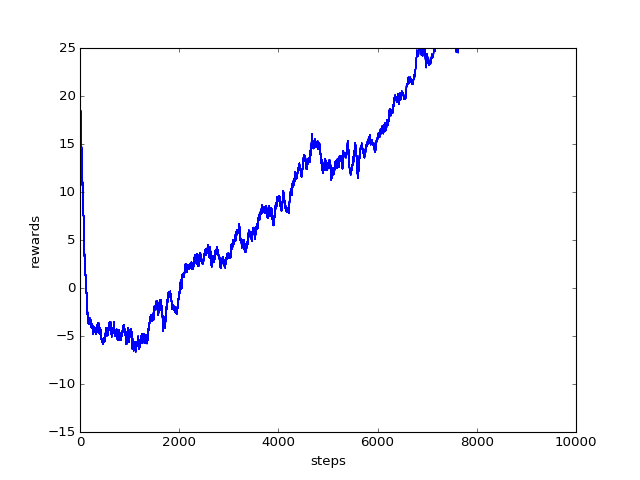

episode 0: starting up...


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:60: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:32: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:39: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:61: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


ep: 0, reward: 20.0, mean reward: 20.000000


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:54: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


	ep: 100, reward: 13.0
y_hat is:  [ 0.09254532  0.18793038  0.11377736  0.04483781  0.04734701  0.06413441
  0.39309868  0.05632901]
	ep: 200, reward: -7.0
y_hat is:  [ 0.06222135  0.05976946  0.02882544  0.0214627   0.02881202  0.01953881
  0.75285703  0.02651312]
y_hat is:  [ 0.10013681  0.06726705  0.04355283  0.05105121  0.09711785  0.05445769
  0.54426223  0.04215432]
y_hat is:  [ 0.1854749   0.08967603  0.04962628  0.02663188  0.13140611  0.0426282
  0.42194915  0.05260755]
	ep: 300, reward: -16.0
	ep: 400, reward: 10.0
y_hat is:  [ 0.08750938  0.05479707  0.05030436  0.03543337  0.56688023  0.0465567
  0.12520339  0.03331544]
y_hat is:  [ 0.02953263  0.02748121  0.01950824  0.03256588  0.75255382  0.03589857
  0.06816109  0.03429853]
y_hat is:  [ 0.03874681  0.03043416  0.02200259  0.03064424  0.72727853  0.03173863
  0.08307882  0.03607621]
y_hat is:  [ 0.03356504  0.02726448  0.02007396  0.02669241  0.75958765  0.02874855
  0.0719405   0.03212739]
ep: 500, reward: -8.0, mean r

KeyboardInterrupt: 

In [11]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('steps') ; ax.set_ylabel('rewards')
ax.set_xlim(0,10000) ; ax.set_ylim(-15,25)
pxs, pys = [], []

print 'episode {}: starting up...'.format(episode_number)
while True:
    
    x = observation

    # stochastically sample a policy from the network
    action = agent.act(np.reshape(x, (1,-1)))

    # step the environment and get new measurements
    observation, reward, done, info = env.step(action)
    agent.rs.append(reward)
    reward_sum += reward
    
    if done:
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01

        # visualization
        pxs.append(episode_number)
        pys.append(running_reward)
        if episode_number % 500 == 0:
            print 'ep: {}, reward: {}, mean reward: {:3f}'.format(episode_number, reward_sum, running_reward)
            plt_dynamic(pxs, pys, ax)
        elif episode_number % 100 == 0:
            print '\tep: {}, reward: {}'.format(episode_number, reward_sum)
            plt_dynamic(pxs, pys, ax)
            
#         if episode_number % 1 == 0:
        agent.learn()
        agent.actor.reset_state()
#         if agent.global_step % 50 == 0:
#             saver.save(agent.sess, save_path, global_step=agent.global_step)
#             print "SAVED MODEL #{}".format(agent.global_step)
        
        # lame stuff
        episode_number += 1 # the Next Episode
        observation = env.reset() # reset env
        reward_sum = 0

In [12]:
saver.save(agent.sess, save_path, global_step=agent.global_step)

'models/model.ckpt-8145'

[[ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  0.  0.  1.  0.  0.
   0.  0.  1.  1.  0.  1.  0.  0.  1.  0.  0.  1.  1.  1.  0.  1.  1.  1.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
   0. -3.  0.  0.  0.  0.  0.  1.  1.  1.  0.  1.  1.  0.  0.  1.  1.  0.
   1.  0.  1.  0.  0.  1.  0.]]
[[ 0.92899686  1.76499176  1.7412343   1.70729566  1.65881145  1.58954847
   1.49060142  1.34924853  1.14731562  0.85884011  0.44673219 -0.14199333
   0.23500575 -0.44445971 -0.19708911  0.15629745 -0.55690008 -0.35771826
  -0.07317274  0.33332086  0.91402602  0.52556908 -0.02936921  0.39589736
  -0.21461457  0.13126108  0.62536913  0.11320224  0.59957087  1.29438317
   1.06893659  0.74686998  0.28677467  0.84753138  0.43057668 -0.16507269
  -1.01600039 -1.01357591 -1.01011217 -1.00516403 -0.99809527 -0.98799711
  -0.97357118 -0.95296258 -0.92352182 -0.88146353 -0.82138032 -0.73554718
  -0.61292833 -0.43775862 -1.40555167 -1.57007778 -1.80511498 -2.14088225
  -2.6

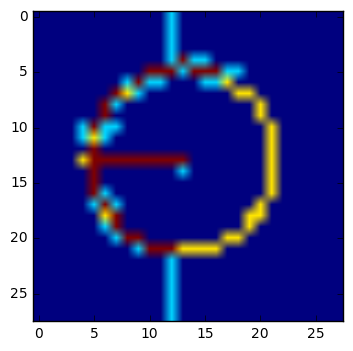

In [13]:
%matplotlib inline
print np.vstack(agent.rs).T
print agent.discounted_r.eval({agent.r:np.vstack(agent.rs)}).T
plt.imshow(env.canvas + 2*env.template)

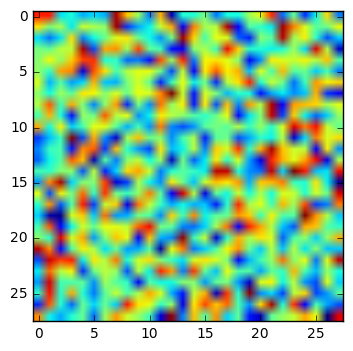

In [22]:
# plt.imshow(np.reshape(np.sum(agent.actor.params['W1'].eval()[:28**2],axis=1),(28,28)))
d = np.random.randint(75)
plt.imshow(np.reshape(agent.actor.params['W1'].eval()[:28**2,d],(28,28)))

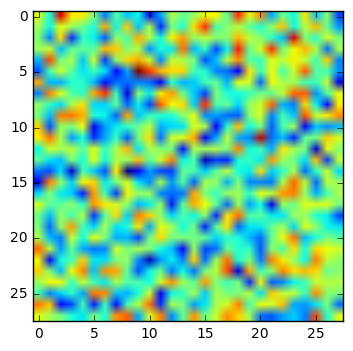

In [36]:
# plt.imshow(np.reshape(np.sum(agent.actor.params['W1'].eval()[28**2:],axis=1),(28,28)))
d = np.random.randint(75)
plt.imshow(np.reshape(agent.actor.params['W1'].eval()[28**2:,d],(28,28)))

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:54: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:60: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:61: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:32: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:39: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


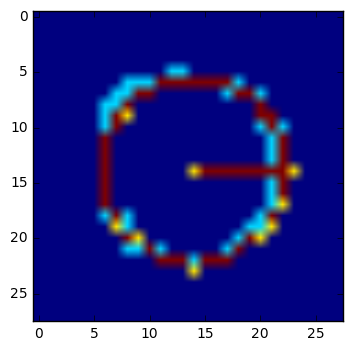

In [89]:
%matplotlib inline
done = False
env = CircleWorld(28)
observation = env.reset() # reset env
agent.epsilon=0

c, h = copy.deepcopy(agent.actor.c), copy.deepcopy(agent.actor.h)
while not done:
    x = observation
    
#     feed = {agent.x: np.reshape(x, (1,-1)), agent.actor.params['istate'].c: c, agent.actor.params['istate'].h: h}
#     fetch = [agent.y_hat, agent.actor.params['fstate'].c, agent.actor.params['fstate'].h]
#     [y_hat, c, h] = agent.sess.run(fetch, feed)
#     print y_hat[0,:4]
        
    action = agent.act(np.reshape(x, (1,-1)))
    observation, reward, done, info = env.step(action)

plt.figure(0)
plt.imshow(env.canvas + 2*env.template)
# plt.imshow(np.reshape(observation,(28,28)))